### Course - CS-513 Knowledge Discovery and Data Mining
#### Problem Statement - Predict the prices of real estate in New York City using the dataset from Kaggle

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [2]:
# Load dataset
df = pd.read_csv('nyc-rolling-sales.csv')

# Check dataset columns pre-cleanup
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

## Data Analysis and Preprocessing

In [3]:
# Clean dataset

print("Removing unwanted columns and replacing weird empty values with NaN")
print("\n")

# Drop Unnamed: 0 feature which is just a serial number
# Drop ADDRESS and LOT features as it is not required for analysis(We are going to use zip code instead)
df.drop(["ADDRESS", "Unnamed: 0", "LOT", "SALE DATE"], axis=1, inplace=True)

# Check and drop columns where all cells are empty or -
df = df.applymap(lambda x: pd.NA if str(x).strip() in ["-", ""] else x)
df.dropna(axis=1, how="all", inplace=True)

print("Dataset columns post-cleanup")
df.info()

Removing unwanted columns and replacing weird empty values with NaN


Dataset columns post-cleanup
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            83810 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   BUILDING CLASS AT PRESENT       83810 non-null  object
 6   APARTMENT NUMBER                19052 non-null  object
 7   ZIP CODE                        84548 non-null  int64 
 8   RESIDENTIAL UNITS               84548 non-null  int64 
 9   COMMERCIAL UNITS                84548 non-null  int64 
 10  TOTAL UNITS                     84548 non-null  int64 
 11  LAND SQ

In [4]:
# View dataset shape and head

print('(Rows, Columns):', df.shape)
df.head()

(Rows, Columns): (84548, 17)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,BUILDING CLASS AT PRESENT,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,C2,<NA>,10009,5,0,5,1633,6440,1900,2,C2,6625000
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,C7,<NA>,10009,28,3,31,4616,18690,1900,2,C7,<NA>
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,C7,<NA>,10009,16,1,17,2212,7803,1900,2,C7,<NA>
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,C4,<NA>,10009,10,0,10,2272,6794,1913,2,C4,3936272
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,C2,<NA>,10009,6,0,6,2369,4615,1900,2,C2,8000000


In [5]:
# Remove rows where commercial units and residential units do not add up to total uints
print(
    "Rows with total units == commercial units + residential units:",
    df[df["TOTAL UNITS"] == df["COMMERCIAL UNITS"] + df["RESIDENTIAL UNITS"]].shape[0],
)

df = df[df["TOTAL UNITS"] == (df["COMMERCIAL UNITS"] + df["RESIDENTIAL UNITS"])]

print(
    "Rows with total units == commercial units + residential units after removing:",
    df[df["TOTAL UNITS"] == df["COMMERCIAL UNITS"] + df["RESIDENTIAL UNITS"]].shape[0],
)

print("\n")

print("Data type of features", df.dtypes)

Rows with total units == commercial units + residential units: 81898
Rows with total units == commercial units + residential units after removing: 81898


Data type of features BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
BUILDING CLASS AT PRESENT         object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
dtype: object


In [6]:
# Find categorical columns - columns with less than 10 unique values considered cateogrical for our purpose

categorical_columns = []

for column in df.columns:
    if df[column].dtype == 'object' or df[column].nunique() < 10:
        categorical_columns.append(column)


print('Categorical columns:')
print(categorical_columns, '\n')

Categorical columns:
['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE'] 



In [7]:
# Filter out categorical features from 'categorical_columns' if they are truly useful in categorical sense
categorical_columns = [
    'BOROUGH',
    'NEIGHBORHOOD',
    'TAX CLASS AT PRESENT',
    'BUILDING CLASS CATEGORY',
    'BUILDING CLASS AT PRESENT',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING CLASS AT TIME OF SALE',
]

for col in categorical_columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

# Convert other feature data types to numeric wherever suitable
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'])
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

In [8]:
# Check if all features are appropriately set as per thier data types
print("Data type of features:")
df.dtypes

Data type of features:


BOROUGH                              int8
NEIGHBORHOOD                        int16
BUILDING CLASS CATEGORY              int8
TAX CLASS AT PRESENT                 int8
BLOCK                               int64
BUILDING CLASS AT PRESENT           int16
APARTMENT NUMBER                   object
ZIP CODE                            int64
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
TOTAL UNITS                         int64
LAND SQUARE FEET                  float64
GROSS SQUARE FEET                 float64
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE            int8
BUILDING CLASS AT TIME OF SALE      int16
SALE PRICE                        float64
dtype: object

In [9]:
# We tried to remove extreme values from SALE PRICE but it resulted in loss of data. So we decided to keep them.

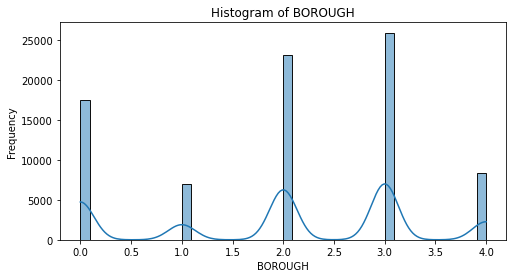

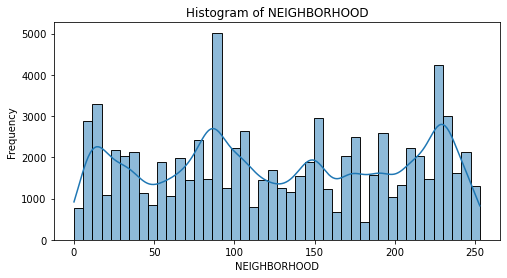

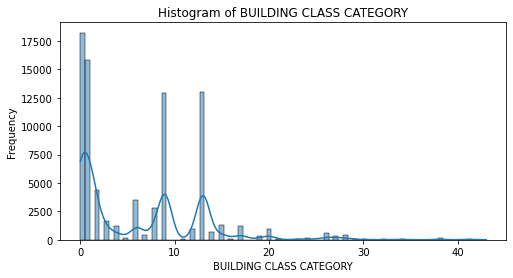

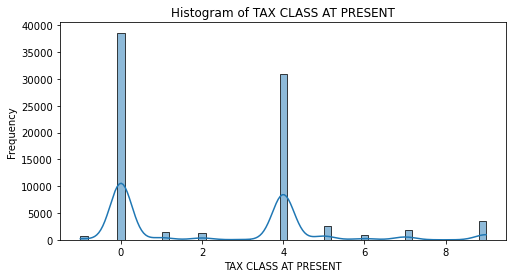

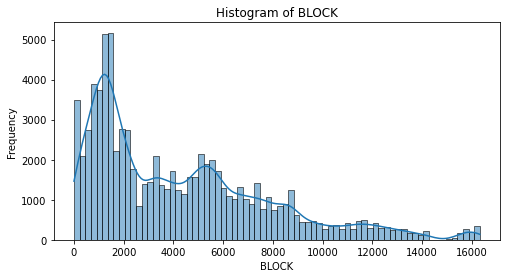

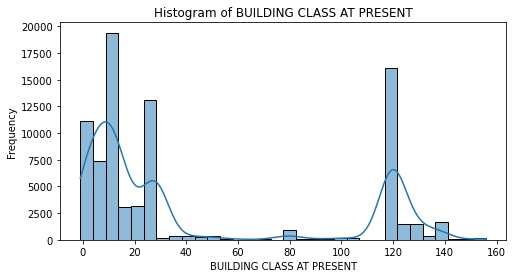

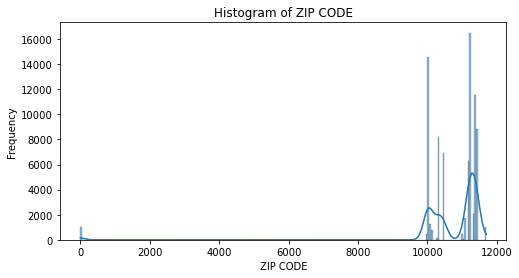

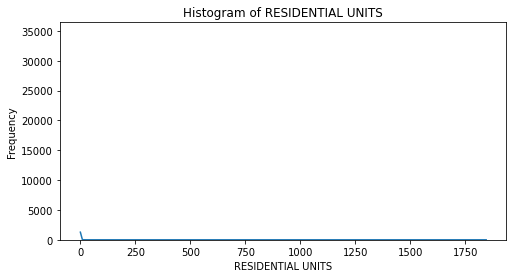

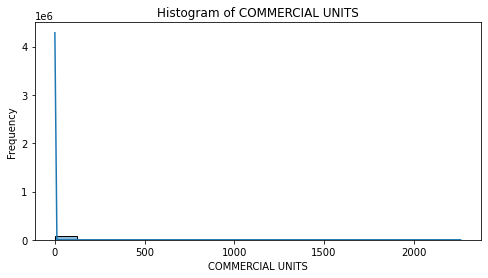

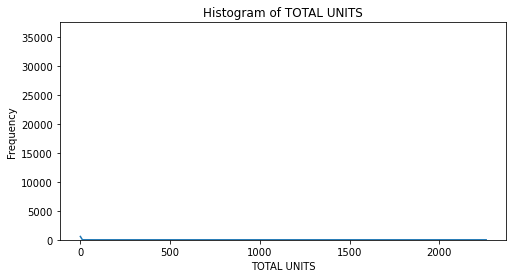

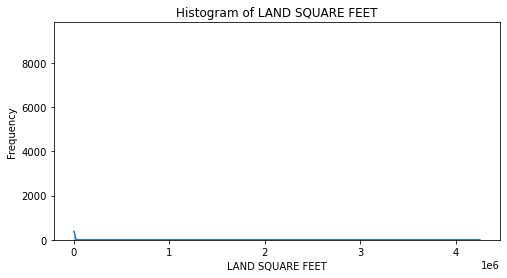

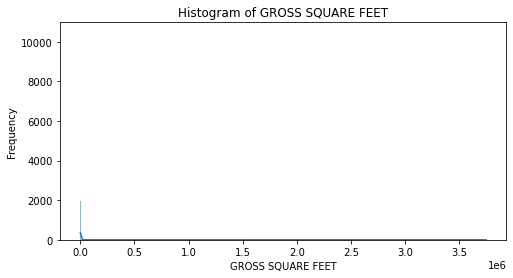

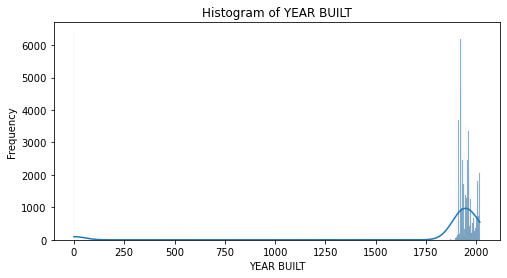

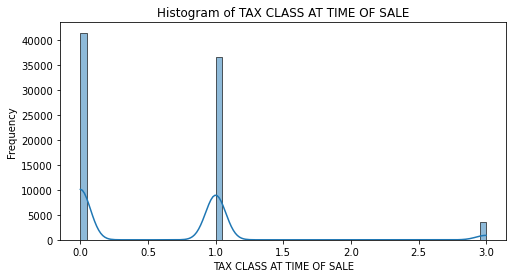

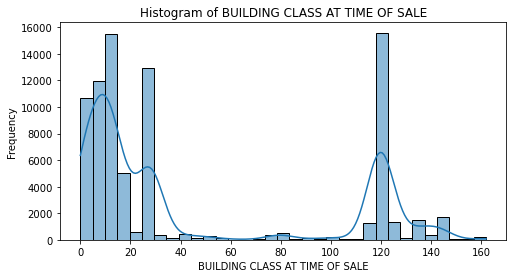

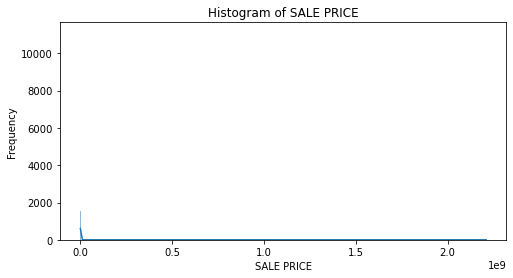

In [10]:
# Plot histogram for numerical data
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

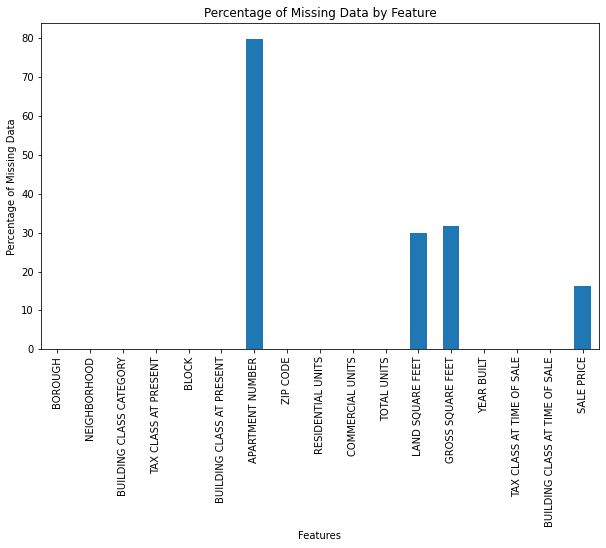

In [11]:
# Missing data - understand percentage of missing data

# Calculate missing % and create a barchart.
def show_missing_values(dataframe):
    missing_percentage = dataframe.isnull().mean() * 100

    plt.figure(figsize=(10, 6))
    missing_percentage.plot(kind="bar")
    plt.ylabel("Percentage of Missing Data")
    plt.xlabel("Features")
    plt.title("Percentage of Missing Data by Feature")
    plt.show()

show_missing_values(df)

## Handle Missing Values

In [12]:
# Treating missing values

# Cateogorical values for SALE PRICE
SALE_PRICE_LABELS = ["Low", "Medium", "High", "Very High"]

# Replace YEAR BUILT = 0 with mode value
df["YEAR BUILT"] = df["YEAR BUILT"].replace(0, df["YEAR BUILT"].mode()[0])

# Remove rows with missing or 0 values in SALE PRICE which is target variable
df["SALE PRICE"] = df["SALE PRICE"].apply(lambda x: np.NAN if x <= 0 or "" else x)
df.dropna(subset=["SALE PRICE"], inplace=True)

# Verify if SALE PRICE has any NA values
print(
    "Number of null or 0 values after cleanup from SALE PRICE:",
    df["SALE PRICE"].isna().sum(),
)

# KNN imputation for 0 values of zip code
imputer = KNNImputer(n_neighbors=5)
df["ZIP CODE"] = imputer.fit_transform(df[["ZIP CODE"]])


# Delete the APARTMENT NUMBER since 77% of the values are missing.
df.drop("APARTMENT NUMBER", axis=1, inplace=True)


# Remove rows with missing values in TAX CLASS AT PRESENT and BUILDING CLASS AT PRESENT
df.dropna(subset=["TAX CLASS AT PRESENT", "BUILDING CLASS AT PRESENT"], inplace=True)


def find_optimal_clusters(standardized_features, df_name, max_k=10):
    """
    Apply the elbow method to find the optimal number of clusters.
    """
    inertia = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(standardized_features)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k + 1), inertia, marker="o")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title(f"Elbow Method for {df_name}")
    plt.show()

    # Calculate the differences between consecutive inertias
    deltas = np.diff(inertia)
    ddeltas = np.diff(deltas)
    elbow_point = np.argmin(ddeltas) + 2

    return elbow_point


def kmeans_remove_outliers(df, df_name):
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(df)

    optimal_k = find_optimal_clusters(standardized_features, df_name)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(standardized_features)
    distances = kmeans.transform(standardized_features)
    closest_cluster_distances = np.min(distances, axis=1)
    threshold_distance = np.mean(closest_cluster_distances) + 3 * np.std(
        closest_cluster_distances
    )
    df = df[closest_cluster_distances > threshold_distance]

    # Finally, change SALE PRICE to categorical variable
    df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)
    return df


df.info()

Number of null or 0 values after cleanup from SALE PRICE: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 58960 entries, 0 to 84547
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         58960 non-null  int8   
 1   NEIGHBORHOOD                    58960 non-null  int16  
 2   BUILDING CLASS CATEGORY         58960 non-null  int8   
 3   TAX CLASS AT PRESENT            58960 non-null  int8   
 4   BLOCK                           58960 non-null  int64  
 5   BUILDING CLASS AT PRESENT       58960 non-null  int16  
 6   ZIP CODE                        58960 non-null  float64
 7   RESIDENTIAL UNITS               58960 non-null  int64  
 8   COMMERCIAL UNITS                58960 non-null  int64  
 9   TOTAL UNITS                     58960 non-null  int64  
 10  LAND SQUARE FEET                38270 non-null  float64
 11  GROSS SQUARE FEET               3

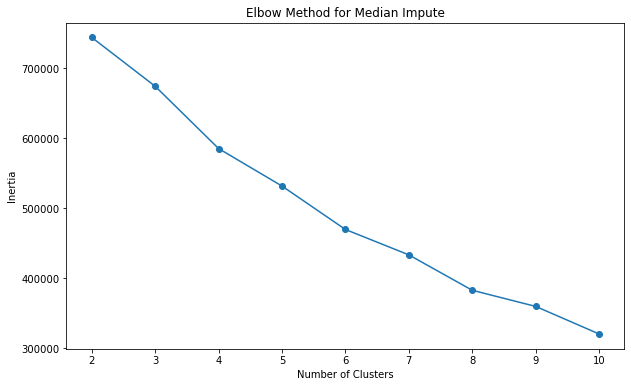

/var/folders/dv/jnqxrkbx5_x2fyjcbdhqfr3h0000gn/T/ipykernel_95572/2143573063.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)


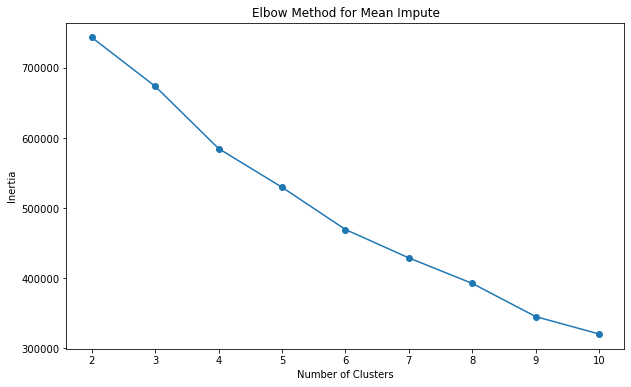

/var/folders/dv/jnqxrkbx5_x2fyjcbdhqfr3h0000gn/T/ipykernel_95572/2143573063.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)


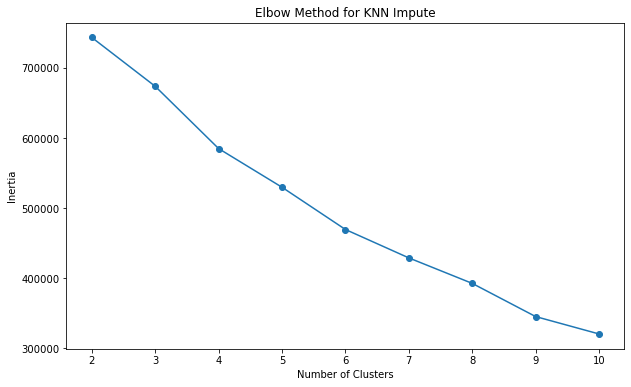

/var/folders/dv/jnqxrkbx5_x2fyjcbdhqfr3h0000gn/T/ipykernel_95572/2143573063.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)


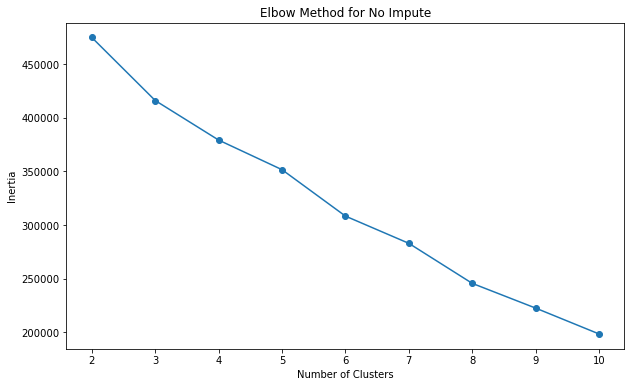

/var/folders/dv/jnqxrkbx5_x2fyjcbdhqfr3h0000gn/T/ipykernel_95572/2143573063.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)


In [13]:
# Create duplicate df for imputation
df_median_impute = df.copy()
df_mean_inpute = df.copy()
df_knn_impute = df.copy()
df_no_impute = df.copy()

# Impute the missing values in LAND SQUARE FEET and GROSS SQUARE FEET using different methods

# Impute using median
df_median_impute['LAND SQUARE FEET'] = df_median_impute['LAND SQUARE FEET'].fillna(df_median_impute['LAND SQUARE FEET'].median())
df_median_impute['GROSS SQUARE FEET'] = df_median_impute['GROSS SQUARE FEET'].fillna(df_median_impute['GROSS SQUARE FEET'].median())
# # do log1p transformation to make the data more normally distributed
# df_median_impute['LAND SQUARE FEET'] = np.log1p(df_median_impute['LAND SQUARE FEET'])
# df_median_impute['GROSS SQUARE FEET'] = np.log1p(df_median_impute['GROSS SQUARE FEET'])

df_median_impute = kmeans_remove_outliers(df_median_impute, "Median Impute")

# Impute using mean
df_mean_inpute['LAND SQUARE FEET'] = df_mean_inpute['LAND SQUARE FEET'].fillna(df_mean_inpute['LAND SQUARE FEET'].mean())
df_mean_inpute['GROSS SQUARE FEET'] = df_mean_inpute['GROSS SQUARE FEET'].fillna(df_mean_inpute['GROSS SQUARE FEET'].mean())
# # do log1p transformation to make the data more normally distributed
# df_mean_inpute['LAND SQUARE FEET'] = np.log1p(df_mean_inpute['LAND SQUARE FEET'])
# df_mean_inpute['GROSS SQUARE FEET'] = np.log1p(df_mean_inpute['GROSS SQUARE FEET'])
df_mean_inpute = kmeans_remove_outliers(df_mean_inpute, "Mean Impute")

# Impute using KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_knn_impute['LAND SQUARE FEET'] = imputer.fit_transform(df_knn_impute[['LAND SQUARE FEET']])
df_knn_impute['GROSS SQUARE FEET'] = imputer.fit_transform(df_knn_impute[['GROSS SQUARE FEET']])
# # do log1p transformation to make the data more normally distributed
# df_knn_impute['LAND SQUARE FEET'] = np.log1p(df_knn_impute['LAND SQUARE FEET'])
# df_knn_impute['GROSS SQUARE FEET'] = np.log1p(df_knn_impute['GROSS SQUARE FEET'])
df_knn_impute = kmeans_remove_outliers(df_knn_impute, "KNN Impute")

# Delete rows with missing values fir df_no_impute
df_no_impute.dropna(inplace=True)
# # do log1p transformation to make the data more normally distributed
# df_no_impute['LAND SQUARE FEET'] = np.log1p(df_no_impute['LAND SQUARE FEET'])
# df_no_impute['GROSS SQUARE FEET'] = np.log1p(df_no_impute['GROSS SQUARE FEET'])
df_no_impute = kmeans_remove_outliers(df_no_impute, "No Impute")

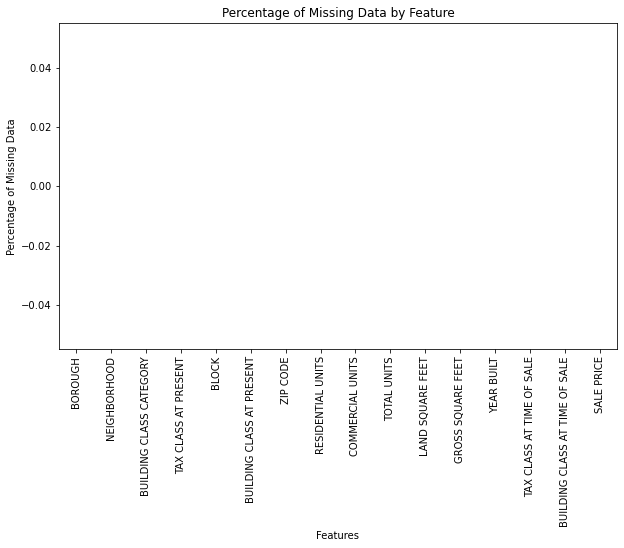

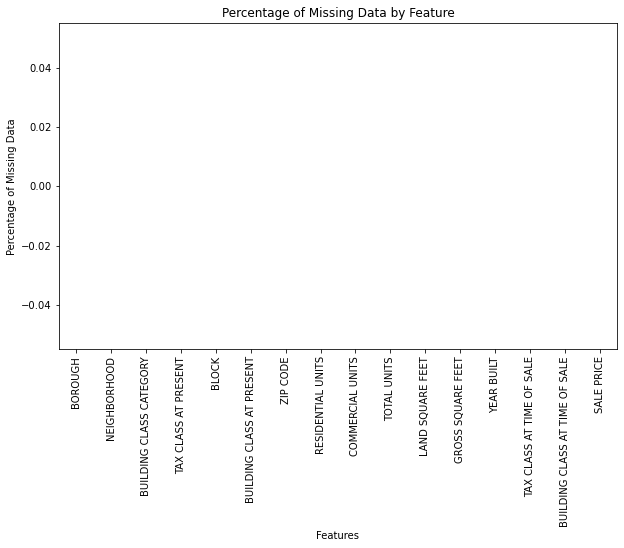

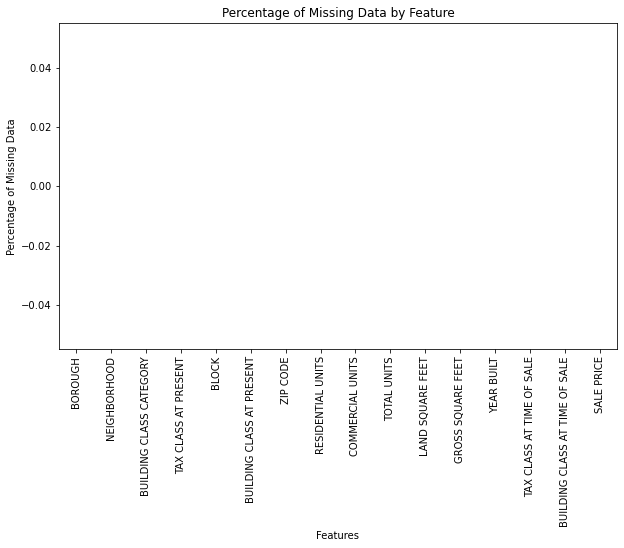

In [14]:
# Showing missing values after cleanup
show_missing_values(df_median_impute)
show_missing_values(df_mean_inpute)
show_missing_values(df_knn_impute)

## Model Predictions

In [15]:
def plot_confusion_matrix(cm, title):
    print(title)
    print(cm)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt="g", ax=ax)

    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title(title)
    ax.xaxis.set_ticklabels(SALE_PRICE_LABELS)
    ax.yaxis.set_ticklabels(SALE_PRICE_LABELS)


def get_predictions(model, attr_train, attr_test, target_train, target_test):
    model.fit(attr_train, target_train)
    return model.predict(attr_test)


# Return optimal k
def get_optimal_k(dataframe):
    attr = dataframe.drop("SALE PRICE", axis=1)
    target = dataframe["SALE PRICE"]

    scaler = MinMaxScaler()
    attr = scaler.fit_transform(attr)

    attr_train, attr_test, target_train, target_test = train_test_split(
        attr, target, test_size=0.3, random_state=42
    )
    k_values = range(1, 21)
    accuracy_map = dict()

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        target_pred = get_predictions(
            knn, attr_train, attr_test, target_train, target_test
        )
        accuracy_map[k] = accuracy_score(target_test, target_pred) * 100

    # Plot the accuracy for different values of k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracy_map.values())
    plt.xticks(k_values)
    plt.xlabel("Value of k")
    plt.ylabel("Testing Accuracy")
    plt.title("Accuracy for different values of k")
    plt.show()

    # Get optimal k
    optimal_k = max(accuracy_map, key=accuracy_map.get)
    return optimal_k


# Return model based on type passed
def get_model(model_type, dataframe):
    if model_type == "gaussian_nb":
        return GaussianNB()
    elif model_type == "decision_tree":
        return DecisionTreeClassifier()
    elif model_type == "cart_5":
        return DecisionTreeClassifier(
            criterion="entropy", max_depth=5, splitter="best", max_leaf_nodes=5
        )
    elif model_type == "random_forest":
        return RandomForestClassifier(n_estimators=100, random_state=7)
    elif model_type == "svm":
        return SVC()
    elif model_type == "knn":
        optimal_k = get_optimal_k(dataframe)
        print("The optimal number of neighbors is {}".format(optimal_k))
        return KNeighborsClassifier(n_neighbors=optimal_k)
    else:
        return None


# Write a common function to train and test the different models
def train_and_test_model(model_type, dataframe):
    # Get the model according to model_type passed
    model = get_model(model_type, dataframe)

    if model is None:
        print("Invalid model type")
        return 0

    attr = dataframe.drop("SALE PRICE", axis=1)
    target = dataframe["SALE PRICE"]

    if model_type == "svm":
        scaler = StandardScaler()
        attr = scaler.fit_transform(attr)
    elif model_type == "knn":
        scaler = MinMaxScaler()
        attr = scaler.fit_transform(attr)

    attr_train, attr_test, target_train, target_test = train_test_split(
        attr, target, test_size=0.3, random_state=42
    )

    target_pred = get_predictions(
        model, attr_train, attr_test, target_train, target_test
    )

    # Get the confusion matrix
    cm = confusion_matrix(target_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for " + model_type)

    # Print the classification report
    print(classification_report(target_test, target_pred))

    # Print the accuracy
    accuracy = accuracy_score(target_test, target_pred)
    print("Accuracy:", accuracy)

    return accuracy


def use_xg_boost_model(dataframe):
    label_encoder = LabelEncoder()

    df = dataframe.copy()
    df["SALE PRICE"] = label_encoder.fit_transform(df["SALE PRICE"])

    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=["category"]).columns

    # Use pd.get_dummies() to create dummy variables for categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    attr = df.drop("SALE PRICE", axis=1)
    target = df["SALE PRICE"]

    attr_train, attr_test, target_train, target_test = train_test_split(
        attr, target, test_size=0.3, random_state=42
    )

    # Define the model
    xgb_classifier = xgb.XGBClassifier()
    xgb_classifier.fit(attr_train, target_train)
    y_pred = xgb_classifier.predict(attr_test)

    # Generate and print the confusion matrix
    cm = confusion_matrix(target_test, y_pred)
    plot_confusion_matrix(cm, "Confusion Matrix for XGBClassifier")

    # Print the classification report
    print(classification_report(target_test, y_pred))

    # Print the accuracy
    accuracy = accuracy_score(target_test, y_pred)
    print("Accuracy:", accuracy)

    return accuracy


def use_sequential_dense_modal(dataframe):
    # Get the feature and target columns
    attr = dataframe.drop("SALE PRICE", axis=1)
    target = dataframe["SALE PRICE"]

    # Convert the target column to categorical (one-hot encoding)
    encoded_target = to_categorical(target.cat.codes)

    # Scale the features
    scaler = StandardScaler()
    scaled_attr = scaler.fit_transform(attr)

    attr_train, attr_test, target_train, target_test = train_test_split(
        scaled_attr, encoded_target, test_size=0.3, random_state=42
    )

    n_features = attr_train.shape[1]

    # Build the neural network model
    model = Sequential()
    model.add(Dense(100, activation="softmax", input_shape=(n_features,)))
    model.add(Dense(100, activation="softmax"))
    model.add(Dense(4, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model.fit(attr_train, target_train, epochs=10, validation_split=0.3)

    loss, accuracy = model.evaluate(attr_test, target_test)
    print(f"Accuracy: {accuracy}")

    return accuracy

Dataframe:  Median Impute


KNN


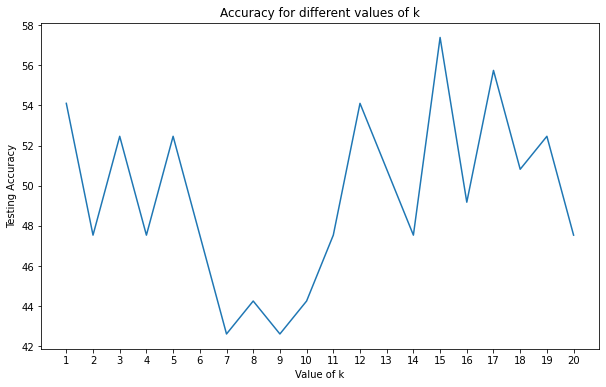

The optimal number of neighbors is 15
Confusion Matrix for knn
[[ 8  0  3  4]
 [ 9  9  2  1]
 [ 2  3  7  0]
 [ 2  0  0 11]]
              precision    recall  f1-score   support

        High       0.38      0.53      0.44        15
         Low       0.75      0.43      0.55        21
      Medium       0.58      0.58      0.58        12
   Very High       0.69      0.85      0.76        13

    accuracy                           0.57        61
   macro avg       0.60      0.60      0.58        61
weighted avg       0.61      0.57      0.57        61

Accuracy: 0.5737704918032787


Gaussian NB
Confusion Matrix for gaussian_nb
[[ 3  4  0  8]
 [ 7 11  0  3]
 [ 1  9  0  2]
 [ 3  3  0  7]]
              precision    recall  f1-score   support

        High       0.21      0.20      0.21        15
         Low       0.41      0.52      0.46        21
      Medium       0.00      0.00      0.00        12
   Very High       0.35      0.54      0.42        13

    accuracy                    

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

Confusion Matrix for random_forest
[[11  0  1  3]
 [ 2  8 10  1]
 [ 1  2  8  1]
 [ 3  0  0 10]]
              precision    recall  f1-score   support

        High       0.65      0.73      0.69        15
         Low       0.80      0.38      0.52        21
      Medium       0.42      0.67      0.52        12
   Very High       0.67      0.77      0.71        13

    accuracy                           0.61        61
   macro avg       0.63      0.64      0.61        61
weighted avg       0.66      0.61      0.60        61

Accuracy: 0.6065573770491803


SVM
Confusion Matrix for svm
[[ 9  0  1  5]
 [ 9  0 11  1]
 [ 3  0  9  0]
 [ 3  0  0 10]]
              precision    recall  f1-score   support

        High       0.38      0.60      0.46        15
         Low       0.00      0.00      0.00        21
      Medium       0.43      0.75      0.55        12
   Very High       0.62      0.77      0.69        13

    accuracy                           0.46        61
   macro avg       0.3

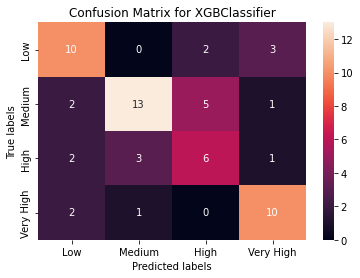

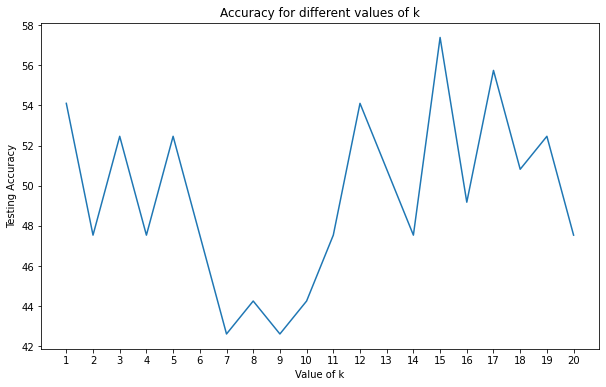

The optimal number of neighbors is 15
Confusion Matrix for knn
[[ 8  0  3  4]
 [ 9  9  2  1]
 [ 2  3  7  0]
 [ 2  0  0 11]]
              precision    recall  f1-score   support

        High       0.38      0.53      0.44        15
         Low       0.75      0.43      0.55        21
      Medium       0.58      0.58      0.58        12
   Very High       0.69      0.85      0.76        13

    accuracy                           0.57        61
   macro avg       0.60      0.60      0.58        61
weighted avg       0.61      0.57      0.57        61

Accuracy: 0.5737704918032787


Gaussian NB
Confusion Matrix for gaussian_nb
[[ 3  4  0  8]
 [ 7 11  0  3]
 [ 1  9  0  2]
 [ 3  3  0  7]]
              precision    recall  f1-score   support

        High       0.21      0.20      0.21        15
         Low       0.41      0.52      0.46        21
      Medium       0.00      0.00      0.00        12
   Very High       0.35      0.54      0.42        13

    accuracy                    

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.65      0.73      0.69        15
         Low       0.89      0.38      0.53        21
      Medium       0.45      0.75      0.56        12
   Very High       0.67      0.77      0.71        13

    accuracy                           0.62        61
   macro avg       0.66      0.66      0.62        61
weighted avg       0.70      0.62      0.62        61

Accuracy: 0.6229508196721312


SVM
Confusion Matrix for svm
[[ 9  0  1  5]
 [ 9  0 11  1]
 [ 3  0  9  0]
 [ 3  0  0 10]]
              precision    recall  f1-score   support

        High       0.38      0.60      0.46        15
         Low       0.00      0.00      0.00        21
      Medium       0.43      0.75      0.55        12
   Very High       0.62      0.77      0.69        13

    accuracy                           0.46        61
   macro avg       0.36      0.53      0.42        61
weighted avg       0.31      0.46      0.37        61

Accuracy:

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix for XGBClassifier
[[ 9  1  2  3]
 [ 3 12  5  1]
 [ 2  1  8  1]
 [ 2  1  0 10]]
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        15
           1       0.80      0.57      0.67        21
           2       0.53      0.67      0.59        12
           3       0.67      0.77      0.71        13

    accuracy                           0.64        61
   macro avg       0.64      0.65      0.64        61
weighted avg       0.66      0.64      0.64        61

Accuracy: 0.639344262295082


Sequential Dense Model
Epoch 1/10
4/4 [==============================] - 0s 22ms/step - loss: 1.3869 - accuracy: 0.2347 - val_loss: 1.3862 - val_accuracy: 0.2326
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 1.3863 - accuracy: 0.2857 - val_loss: 1.3863 - val_accuracy: 0.2326
Epoch 3/10
4/4 [==============================] - 0s 5ms/step - loss: 1.3860 - accuracy: 0.2857 - val_loss: 1.3866 - val_accuracy: 0.2326
E

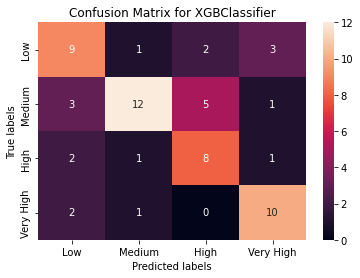

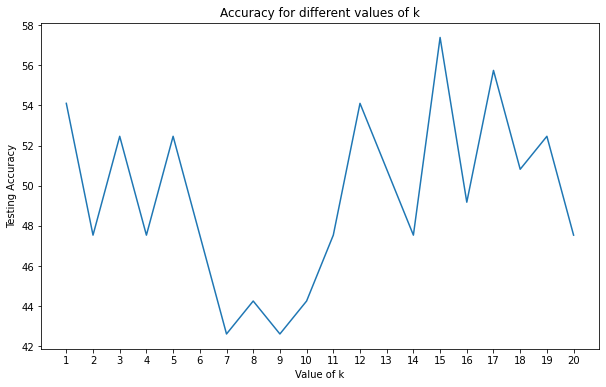

The optimal number of neighbors is 15
Confusion Matrix for knn
[[ 8  0  3  4]
 [ 9  9  2  1]
 [ 2  3  7  0]
 [ 2  0  0 11]]
              precision    recall  f1-score   support

        High       0.38      0.53      0.44        15
         Low       0.75      0.43      0.55        21
      Medium       0.58      0.58      0.58        12
   Very High       0.69      0.85      0.76        13

    accuracy                           0.57        61
   macro avg       0.60      0.60      0.58        61
weighted avg       0.61      0.57      0.57        61

Accuracy: 0.5737704918032787


Gaussian NB
Confusion Matrix for gaussian_nb
[[ 3  4  0  8]
 [ 7 11  0  3]
 [ 1  9  0  2]
 [ 3  3  0  7]]
              precision    recall  f1-score   support

        High       0.21      0.20      0.21        15
         Low       0.41      0.52      0.46        21
      Medium       0.00      0.00      0.00        12
   Very High       0.35      0.54      0.42        13

    accuracy                    

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.65      0.73      0.69        15
         Low       0.89      0.38      0.53        21
      Medium       0.45      0.75      0.56        12
   Very High       0.67      0.77      0.71        13

    accuracy                           0.62        61
   macro avg       0.66      0.66      0.62        61
weighted avg       0.70      0.62      0.62        61

Accuracy: 0.6229508196721312


SVM
Confusion Matrix for svm
[[ 9  0  1  5]
 [ 9  0 11  1]
 [ 3  0  9  0]
 [ 3  0  0 10]]
              precision    recall  f1-score   support

        High       0.38      0.60      0.46        15
         Low       0.00      0.00      0.00        21
      Medium       0.43      0.75      0.55        12
   Very High       0.62      0.77      0.69        13

    accuracy                           0.46        61
   macro avg       0.36      0.53      0.42        61
weighted avg       0.31      0.46      0.37        61

Accuracy:

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix for XGBClassifier
[[ 9  1  2  3]
 [ 3 12  5  1]
 [ 2  1  8  1]
 [ 2  1  0 10]]
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        15
           1       0.80      0.57      0.67        21
           2       0.53      0.67      0.59        12
           3       0.67      0.77      0.71        13

    accuracy                           0.64        61
   macro avg       0.64      0.65      0.64        61
weighted avg       0.66      0.64      0.64        61

Accuracy: 0.639344262295082


Sequential Dense Model
Epoch 1/10
4/4 [==============================] - 0s 24ms/step - loss: 1.3834 - accuracy: 0.2857 - val_loss: 1.3877 - val_accuracy: 0.2326
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 1.3827 - accuracy: 0.2857 - val_loss: 1.3881 - val_accuracy: 0.2326
Epoch 3/10
4/4 [==============================] - 0s 10ms/step - loss: 1.3823 - accuracy: 0.2857 - val_loss: 1.3883 - val_accuracy: 0.2326


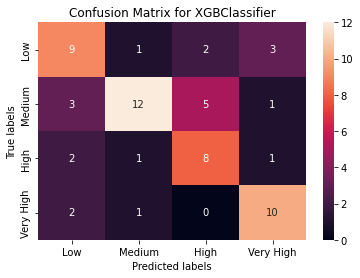

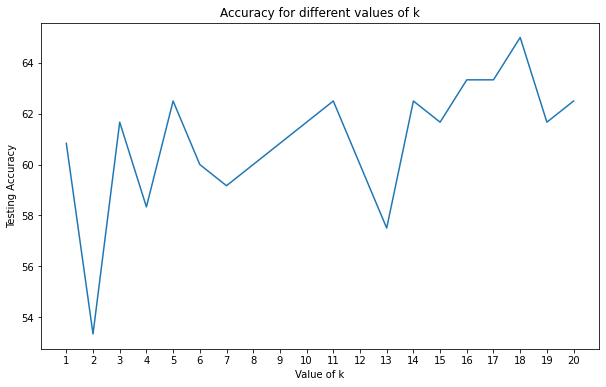

The optimal number of neighbors is 18
Confusion Matrix for knn
[[18  3  1  1]
 [ 1 25  0  1]
 [19  7  7  2]
 [ 1  6  0 28]]
              precision    recall  f1-score   support

        High       0.46      0.78      0.58        23
         Low       0.61      0.93      0.74        27
      Medium       0.88      0.20      0.33        35
   Very High       0.88      0.80      0.84        35

    accuracy                           0.65       120
   macro avg       0.71      0.68      0.62       120
weighted avg       0.74      0.65      0.62       120

Accuracy: 0.65


Gaussian NB
Confusion Matrix for gaussian_nb
[[22  0  0  1]
 [24  1  0  2]
 [29  4  0  2]
 [ 2  2  0 31]]
              precision    recall  f1-score   support

        High       0.29      0.96      0.44        23
         Low       0.14      0.04      0.06        27
      Medium       0.00      0.00      0.00        35
   Very High       0.86      0.89      0.87        35

    accuracy                           0.45   

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

              precision    recall  f1-score   support

        High       0.43      0.83      0.57        23
         Low       0.61      0.70      0.66        27
      Medium       0.62      0.29      0.39        35
   Very High       0.97      0.80      0.88        35

    accuracy                           0.63       120
   macro avg       0.66      0.65      0.62       120
weighted avg       0.68      0.63      0.63       120

Accuracy: 0.6333333333333333


SVM
Confusion Matrix for svm
[[13  3  6  1]
 [ 0 27  0  0]
 [12  9 13  1]
 [ 1  8  0 26]]
              precision    recall  f1-score   support

        High       0.50      0.57      0.53        23
         Low       0.57      1.00      0.73        27
      Medium       0.68      0.37      0.48        35
   Very High       0.93      0.74      0.83        35

    accuracy                           0.66       120
   macro avg       0.67      0.67      0.64       120
weighted avg       0.70      0.66      0.65       120

Accuracy:

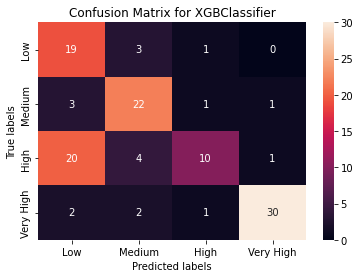

In [16]:
# Map each dataframe to a key and execute different models on it
# Save accuracies of every model for each dataframe in a dictionary

df_map = {
    "Median Impute": df_median_impute,
    "Mean Impute": df_mean_inpute,
    "KNN Impute": df_knn_impute,
    "No Impute": df_no_impute,
}

accuracy_map = dict()

for df_key in df_map.keys():
    print("Dataframe: ", df_key)
    print("\n")

    df_item = df_map[df_key]
    accuracy_map[df_key] = dict()

    print("KNN")
    accuracy_map[df_key]["knn"] = train_and_test_model("knn", df_item)
    print("\n")

    print("Gaussian NB")
    accuracy_map[df_key]["gaussian_nb"] = train_and_test_model("gaussian_nb", df_item)
    print("\n")

    print("Decision Tree")
    accuracy_map[df_key]["decision_tree"] = train_and_test_model("decision_tree", df_item)
    print("\n")

    print("CART 5")
    accuracy_map[df_key]["cart_5"] = train_and_test_model("cart_5", df_item)
    print("\n")

    print("Random Forest")
    accuracy_map[df_key]["random_forest"] = train_and_test_model("random_forest", df_item)
    print("\n")

    print("SVM")
    accuracy_map[df_key]["svm"] = train_and_test_model("svm", df_item)
    print("\n")

    print("XG Boost")
    accuracy_map[df_key]["xg_boost"] = use_xg_boost_model(df_item)
    print("\n")

    print("Sequential Dense Model")
    accuracy_map[df_key]["ann"] = use_sequential_dense_modal(df_item)
    print("\n\n")

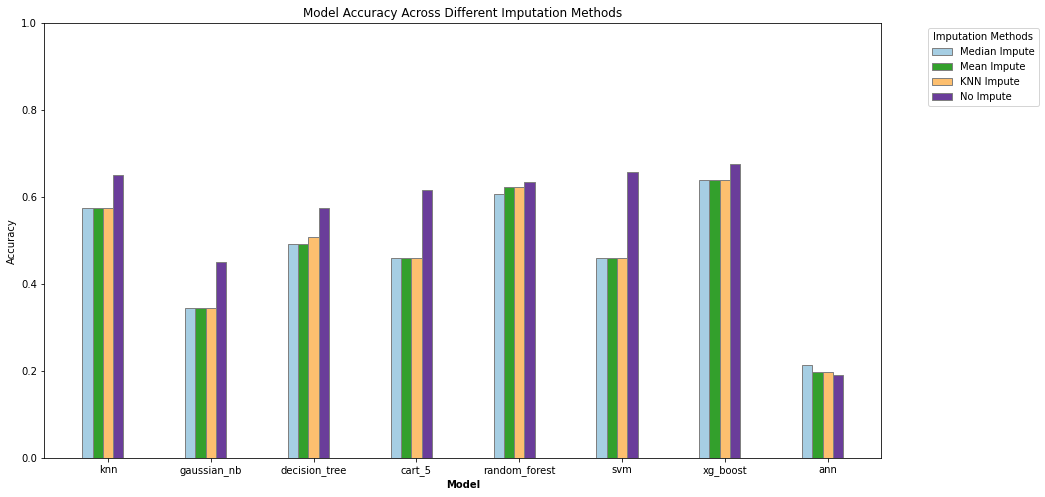

In [17]:
# Using the accuracies map and plotting a bar chart to compare the accuracies of different models acros different imputation methods

models = ["knn", "gaussian_nb", "decision_tree", "cart_5", "random_forest", "svm", "xg_boost", "ann"]

dfs = df_map.keys()
num_groups = len(models)
r = np.arange(num_groups)

bar_width = 0.1

plt.figure(figsize=(15, 8))
for i, df_name in enumerate(dfs):
    accuracies = [accuracy_map[df_name].get(model, 0) for model in models]
    plt.bar(r + i * bar_width, accuracies, color=plt.cm.Paired(i / len(dfs)), width=bar_width, edgecolor='gray', label=df_name)

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width * (len(dfs) / 2) for r in range(num_groups)], models)

plt.legend(title="Imputation Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Across Different Imputation Methods')
plt.ylim(0, 1)

plt.show()

## Finding the best model, best dataset and calculating its accuracy

In [18]:
# Get the model with highest accuracy
max_accuracy = 0
max_accuracy_model = None
max_accuracy_df = None

for df_key in accuracy_map.keys():
    for model in accuracy_map[df_key].keys():
        if accuracy_map[df_key][model] > max_accuracy:
            max_accuracy = accuracy_map[df_key][model]
            max_accuracy_model = model
            max_accuracy_df = df_key

print("Max accuracy:", max_accuracy)
print("Max accuracy model:", max_accuracy_model)
print("Max accuracy df:", max_accuracy_df)

Max accuracy: 0.675
Max accuracy model: xg_boost
Max accuracy df: No Impute


Confusion Matrix for XGBClassifier
[[19  3  1  0]
 [ 3 22  1  1]
 [20  4 10  1]
 [ 2  2  1 30]]
              precision    recall  f1-score   support

           0       0.43      0.83      0.57        23
           1       0.71      0.81      0.76        27
           2       0.77      0.29      0.42        35
           3       0.94      0.86      0.90        35

    accuracy                           0.68       120
   macro avg       0.71      0.70      0.66       120
weighted avg       0.74      0.68      0.66       120

Accuracy: 0.675


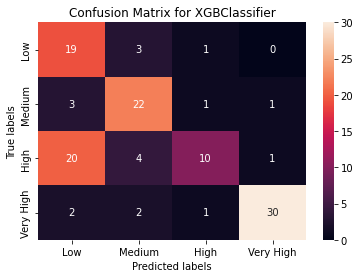

In [19]:
# Calculate the accuracy one last time
if max_accuracy_model == 'xg_boost':
    use_xg_boost_model(df_map[max_accuracy_df])
elif max_accuracy_model == 'ann':
    use_sequential_dense_modal(df_map[max_accuracy_df])
else:
    train_and_test_model(max_accuracy_model, df_map[max_accuracy_df])